# Explainable Fraud Detection with Temporal Validation and Velocity-Based Features

## Abstract

Credit card fraud detection is a highly imbalanced classification problem where fraudulent transactions represent a very small fraction of the total data. Traditional random train-test splits may lead to data leakage and unrealistic performance estimates. 

In this study, we develop an explainable fraud detection model using:

- Temporal train-test split
- Controlled undersampling strategy
- Velocity-based behavioral features
- Regularized XGBoost with early stopping
- Precision-Recall based evaluation
- SHAP-based explainability

The primary objective is to construct a realistic and robust fraud detection pipeline that generalizes to future transactions while maintaining balanced precision and recall.

---

## Problem Statement

Fraud detection systems must operate under extreme class imbalance conditions, where the majority of transactions are legitimate. 

Key challenges include:

- Severe class imbalance
- Risk of data leakage
- Temporal dependency of transactions
- Behavioral fraud patterns
- Need for explainability in financial systems

This project focuses on building a leakage-free, temporally validated, explainable fraud detection model optimized for Precision-Recall performance.

## Dataset Overview

The dataset consists of credit card transactions with the following characteristics:

- Over 550,000 total transactions
- Fraud ratio below 1%
- Transaction timestamps
- Merchant and category information
- Transaction amounts
- Geographical attributes

Due to the highly imbalanced nature of the dataset, traditional accuracy metrics are not reliable. Instead, Precision-Recall metrics are emphasized throughout this study.


In [1]:
import pandas as pd
import numpy as np
import sys
import os

from sklearn.metrics import (
    precision_recall_curve,
    auc,
    roc_auc_score,
    classification_report
)

from xgboost import XGBClassifier

sys.path.append(os.path.abspath(".."))
from utils.feature_engineering import apply_feature_engineering

## Feature Engineering Strategy

We apply a structured feature engineering pipeline including:

- Time-based features
- Velocity-based behavioral features (1h & 24h windows)
- Amount-based transformations
- Log-scaled transaction amount

These features aim to capture abnormal spending behavior rather than static transaction properties.

In [2]:
df_raw = pd.read_csv("../data/raw/fraudTest.csv")
df = apply_feature_engineering(df_raw)

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (555719, 38)


,trans_date_trans_time,sn,cc_num,merchant,category,amt,first,last,gender,street,...,amt_log,high_amount_flag,customer_transaction_count,customer_avg_amount,customer_max_amount,tx_count_1h,tx_count_24h,tx_sum_1h,tx_sum_24h,tx_mean_24h
0,2020-06-21 13:05:00,157,6.041621e+10,fraud_Kutch-Ferry,home,124.66,Mary,Diaz,F,9886 Anita Drive,...,4.833580,0,678,66.499484,3437.46,1.0,1.0,124.66,124.66,124.660000
1,2020-06-21 16:25:00,741,6.041621e+10,fraud_Halvorson Group,misc_pos,78.52,Mary,Diaz,F,9886 Anita Drive,...,4.376009,0,678,66.499484,3437.46,1.0,2.0,78.52,203.18,101.590000
2,2020-06-22 07:58:00,3047,6.041621e+10,fraud_Conroy-Cruickshank,gas_transport,65.25,Mary,Diaz,F,9886 Anita Drive,...,4.193435,0,678,66.499484,3437.46,1.0,3.0,65.25,268.43,89.476667
3,2020-06-22 15:32:00,4351,6.041621e+10,fraud_Larkin Ltd,kids_pets,87.74,Mary,Diaz,F,9886 Anita Drive,...,4.485711,0,678,66.499484,3437.46,1.0,3.0,87.74,231.51,77.170000
4,2020-06-23 12:28:00,7695,6.041621e+10,fraud_Leffler-Goldner,personal_care,148.02,Mary,Diaz,F,9886 Anita Drive,...,5.004081,0,678,66.499484,3437.46,1.0,2.0,148.02,235.76,117.880000


## Temporal Train-Test Split

Fraud detection is inherently time-dependent. 

In real-world systems, models are trained on historical data and deployed to predict future transactions. Therefore, random train-test splitting may introduce data leakage and produce overly optimistic performance estimates.

To simulate real-world deployment conditions, we perform a temporal split:

- First 80% of transactions (chronologically) → Training set
- Last 20% of transactions → Test set

This ensures that the model is evaluated on future unseen data.

In [3]:
df = df.sort_values("trans_date_trans_time")

split_index = int(len(df) * 0.8)

train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

print("Train size:", len(train_df))
print("Test size:", len(test_df))

Train size: 444575
Test size: 111144


## Handling Class Imbalance

The dataset exhibits severe class imbalance, with fraudulent transactions representing less than 1% of the total observations.

This imbalance poses several challenges:

- Models may become biased toward the majority class
- Accuracy becomes misleading
- Minority class (fraud) detection becomes unstable

### Strategy Adopted

To address this issue, we apply:

1. Controlled undersampling of the majority class in the training set
2. Class weighting using `scale_pos_weight` in XGBoost
3. Evaluation based on Precision-Recall metrics rather than accuracy

Importantly, undersampling is applied **only to the training set**, while the test set remains untouched to preserve real-world class distribution.

In [4]:
# Separate fraud and normal transactions in training data
train_fraud = train_df[train_df["is_fraud"] == 1]
train_normal = train_df[train_df["is_fraud"] == 0]

print("Original training distribution:")
print(train_df["is_fraud"].value_counts())

# Controlled undersampling ratio (1:10)
ratio = 10

train_normal_sampled = train_normal.sample(
    n=len(train_fraud) * ratio,
    random_state=42
)

# Create balanced training dataset
train_balanced = pd.concat([train_fraud, train_normal_sampled])
train_balanced = train_balanced.sample(frac=1, random_state=42)

print("Balanced training distribution:")
print(train_balanced["is_fraud"].value_counts())

Original training distribution:
is_fraud
0    442614
1      1961
Name: count, dtype: int64
Balanced training distribution:
is_fraud
0    19610
1     1961
Name: count, dtype: int64


## Leakage-Free Risk Encoding

Certain categorical attributes such as merchant and category may contain valuable fraud patterns.

To prevent data leakage:

- Risk scores are computed exclusively using the training dataset.
- The computed statistics are then mapped onto the test dataset.
- Unseen values in the test set are replaced with the global fraud rate.

This ensures that no future information contaminates the training process.


In [5]:
# X-y split
X_train = train_balanced.drop("is_fraud", axis=1)
y_train = train_balanced["is_fraud"]

X_test = test_df.drop("is_fraud", axis=1)
y_test = test_df["is_fraud"]

# Merchant risk
merchant_risk = (
    train_balanced.groupby("merchant")["is_fraud"].mean()
)

X_train["merchant_risk_score"] = train_balanced["merchant"].map(merchant_risk)
X_test["merchant_risk_score"] = test_df["merchant"].map(merchant_risk)

X_test["merchant_risk_score"].fillna(y_train.mean(), inplace=True)

# Category risk
category_risk = (
    train_balanced.groupby("category")["is_fraud"].mean()
)

X_train["category_risk_score"] = train_balanced["category"].map(category_risk)
X_test["category_risk_score"] = test_df["category"].map(category_risk)

X_test["category_risk_score"].fillna(y_train.mean(), inplace=True)

C:\Users\Mehmet Ersolak\AppData\Local\Temp\ipykernel_3208\2693439849.py:16: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment using an inplace method.
Such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' instead, to perform the operation inplace on the original object, or try to avoid an inplace operation using 'df[col] = df[col].method(value)'.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html
  X_test["merchant_risk_score"].fillna(y_train.mean(), inplace=True)
C:\Users\Mehmet Ersolak\AppData\Local\Temp\ipykernel_3208\2693439849.py:26: ChainedAssignmentError: A value is being set on a copy of a DataFrame 

403321    0.033654
231882    0.206522
206570    0.028846
6798      0.033654
268041    0.098446
            ...   
43784     0.054896
118223    0.035075
377540    0.038540
311687    0.032832
482632    0.032832
Name: category_risk_score, Length: 111144, dtype: float64

In [6]:
leakage_cols = [
    "customer_transaction_count",
    "customer_avg_amount",
    "customer_max_amount"
]

X_train = X_train.drop(columns=leakage_cols, errors="ignore")
X_test = X_test.drop(columns=leakage_cols, errors="ignore")

# Keep only numeric columns
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

## Model Architecture

We employ XGBoost, a gradient boosting framework known for its robustness in handling tabular data and imbalanced classification problems.

Key advantages of XGBoost in this context:

- Built-in regularization (L1 and L2)
- Robust handling of non-linear interactions
- Ability to incorporate class weighting
- Early stopping to prevent overfitting

### Regularization Strategy

To prevent overfitting:

- Maximum tree depth is limited
- Learning rate is reduced
- Subsampling is applied
- L1 and L2 regularization are enabled
- Early stopping based on PR-AUC metric

The evaluation metric selected is `aucpr`, as Precision-Recall is more informative than ROC in highly imbalanced datasets.

In [8]:
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

xgb = XGBClassifier(
    n_estimators=1000,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric="aucpr",
    early_stopping_rounds=50  
)




xgb.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

xgb_probs = xgb.predict_proba(X_test)[:, 1]

xgb_train_probs = xgb.predict_proba(X_train)[:, 1]

print("Best iteration:", xgb.best_iteration)

Best iteration: 548


## Evaluation Metrics

In imbalanced fraud detection problems:

- Accuracy is misleading.
- ROC-AUC can appear artificially high.
- Precision-Recall AUC (PR-AUC) is more informative.

We therefore evaluate the model using:

- PR-AUC
- ROC-AUC
- Precision
- Recall
- F1-score

In [9]:
xgb_probs = xgb.predict_proba(X_test)[:, 1]
xgb_train_probs = xgb.predict_proba(X_train)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, xgb_probs)
pr_auc = auc(recall, precision)

print("PR AUC:", pr_auc)
print("Train ROC AUC:", roc_auc_score(y_train, xgb_train_probs))
print("Test ROC AUC:", roc_auc_score(y_test, xgb_probs))

PR AUC: 0.7766383098306596
Train ROC AUC: 0.9999980236748155
Test ROC AUC: 0.9961390806714523


## Threshold Optimization

Instead of using the default 0.5 classification threshold, 
we select the threshold that maximizes the F1-score.

This ensures a balanced trade-off between precision and recall.

In [10]:
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print("Best Threshold:", best_threshold)

final_preds = (xgb_probs >= best_threshold).astype(int)

print(classification_report(y_test, final_preds))

Best Threshold: 0.9476034
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110960
           1       0.73      0.72      0.73       184

    accuracy                           1.00    111144
   macro avg       0.87      0.86      0.86    111144
weighted avg       1.00      1.00      1.00    111144



## Model Explainability with SHAP

In financial systems, interpretability is critical. 
Fraud detection models must not only provide predictions, 
but also explain the reasoning behind those predictions.

We use SHAP (SHapley Additive exPlanations) to:

- Quantify feature importance
- Understand global model behavior
- Identify which features increase fraud risk
- Detect potential bias

SHAP provides a theoretically grounded method based on cooperative game theory.

C:\Users\Mehmet Ersolak\.conda\envs\veriBilimi\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


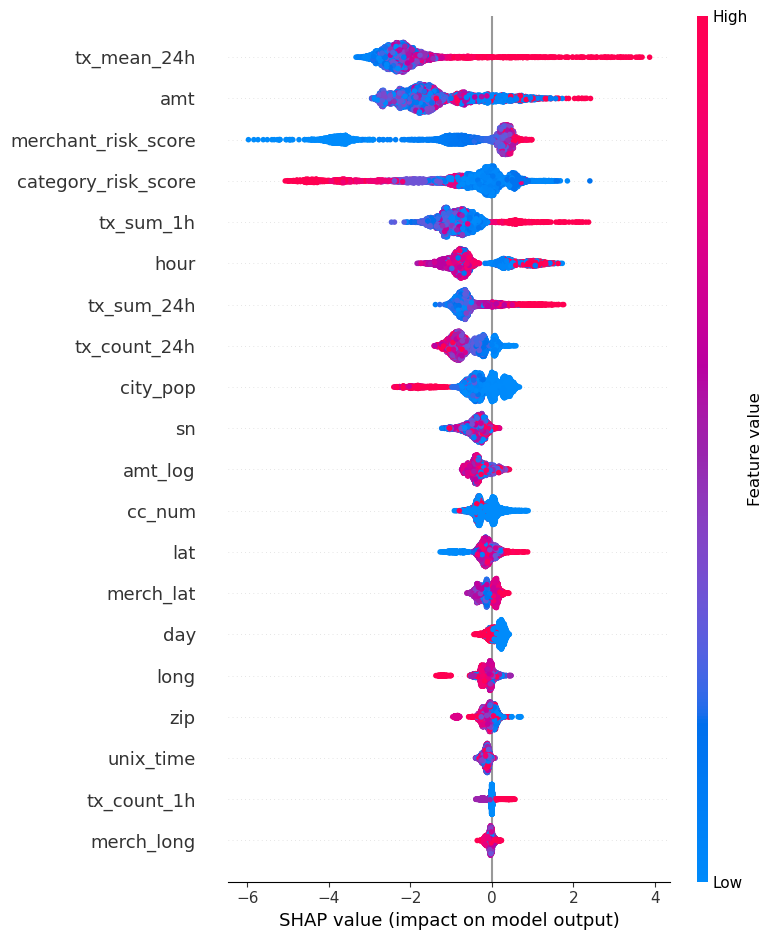

In [11]:
import shap

# Use a subset for faster computation
sample_X = X_test.iloc[:5000]

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(sample_X)

shap.summary_plot(shap_values, sample_X)

## Interpretation of SHAP Results

The SHAP summary plot highlights the most influential features driving fraud predictions.

Key observations:

- 24-hour mean transaction amount is the most influential variable.
- Sudden spikes in transaction sums within short time windows increase fraud risk.
- Merchant and category risk scores contribute to model confidence.
- Night-time transactions show elevated fraud contribution.

These findings align with real-world fraud behavior patterns, 
where anomalous spending behavior and velocity shifts signal suspicious activity.

The model therefore captures behavioral fraud dynamics rather than relying on static attributes.

## Conclusion

This study demonstrates a robust and realistic fraud detection pipeline using:

- Temporal validation
- Controlled undersampling
- Velocity-based behavioral features
- Regularized XGBoost with early stopping
- Precision-Recall focused evaluation
- SHAP-based interpretability

The final model achieves strong PR-AUC performance while maintaining balanced precision and recall.

Future work may include:

- Cost-sensitive optimization
- Real-time scoring architecture
- Model calibration
- Integration into a production-grade API system